# SN Ia

This notebook explores how to normalize the SN Ia DTD given by Maoz and Graur 2017.

In [1]:
import tabulation
import numpy as np
import betterplotlib as bpl
from scipy import integrate
from astropy import units as u
from astropy import cosmology

bpl.presentation_style()

In [2]:
bpl.presentation_style()

In [3]:
lifetimes = tabulation.Lifetimes("Raiteri_96")

There are options in exactly how to parametrize the DTD. We can do

$$ r(t) \propto t^{-1.13} $$ 

where we just use the raw age, or we can scale the age to the age of the 8 solar mass star.

$$ r(t) \propto \left( \frac{t}{\tau(8)} \right)^{-1.13} $$

These options matter since the lifetimes vary with metallicity, changing $\tau(8)$. We want to choose one of these options. The first is the same at late times for all metallicities, while the second has the same peak height for all metallicities.

In [4]:
new_art_s = 1.13

def z_dependent_rate_scaled(age, z):
    age_8 = lifetimes.lifetime(8.0, z)
    if age < age_8:
        return 0
    else:
        return (age / age_8) ** (-new_art_s)
    
def z_dependent_rate_raw(age, z):
    age_8 = lifetimes.lifetime(8.0, z)
    if age < age_8:
        return 0
    else:
        return age ** (-new_art_s)

In [5]:
z_test = [1E-6, 1E-5, 1E-4, 1E-3, 1E-2, 0.02, 0.04]
z_plot = [1E-4, 1E-3, 2E-2]

Plot them to see these differences visually.

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


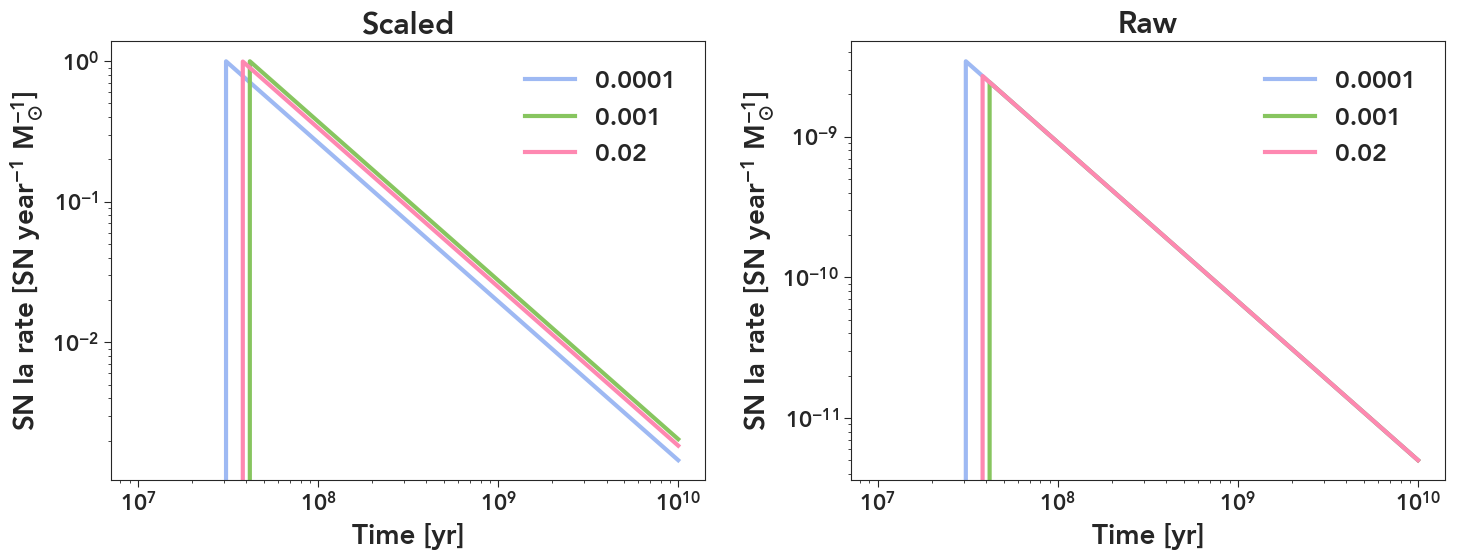

In [6]:
fig, axs = bpl.subplots(ncols=2, figsize=[15, 6])
ages = np.logspace(7, 10, 1000)
for z in z_plot:
    rate_raw = [z_dependent_rate_raw(a, z) for a in ages]
    rate_scaled = [z_dependent_rate_scaled(a, z) for a in ages]
    
    axs[0].plot(ages, rate_scaled, label=z)
    axs[1].plot(ages, rate_raw, label=z)

for ax in axs:
    ax.add_labels("Time [yr]", "SN Ia rate [SN year$^{-1}$ M$^{-1}_\odot$]")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.legend()
    
axs[0].set_title("Scaled")
axs[1].set_title("Raw");

Test how they integrate. For better normalization, we'd like them to be pretty consistent at all metallicities.

In [7]:
for z in z_test:
    integral = integrate.quad(z_dependent_rate_scaled, 0, 14E9, args=[z])[0]
    age_8 = lifetimes.lifetime(8, z)
    print("{:7f} {:.3E} {:.2E}".format(z, age_8, integral))

0.000001 2.850E+07 1.21E+08
0.000010 2.850E+07 1.21E+08
0.000100 3.076E+07 1.30E+08
0.001000 4.172E+07 1.70E+08
0.010000 4.078E+07 1.67E+08
0.020000 3.798E+07 1.57E+08
0.040000 3.594E+07 1.49E+08


Here metallicities with shorter lifetimes contribute less over roughly a Hubble time.

In [8]:
for z in z_test:
    integral = integrate.quad(z_dependent_rate_raw, 0, 14E9, args=[z])[0]
    age_8 = lifetimes.lifetime(8, z)
    print("{:7f} {:.3E} {:.2E}".format(z, age_8, integral))

0.000001 2.850E+07 4.57E-01
0.000010 2.850E+07 4.57E-01
0.000100 3.076E+07 4.49E-01
0.001000 4.172E+07 4.17E-01
0.010000 4.078E+07 4.19E-01
0.020000 3.798E+07 4.27E-01
0.040000 3.594E+07 4.32E-01


Here metallicities with shorter lifetimes contribute more over a Hubble time. This seems more justified, since more white dwarfs will be created (since more stars die), therefore more SN Ia is reasonable.

The raw version is clearly more stable. This is because the early times don't contribute much. Late times are much more important (since we integrate over time, not log time as shown in the plots). Having equal values at late times is more important to keeping the rates equal.

The raw version seems to be better.

# Determining normalization

We want the total number of SN Ia to match the normalization given in Maoz and Graur 2017, Table 3 for field galaxies: $N/M_{\star} = 1.6^{+0.3}_{-0.3} \times 10^{-3}$ over a Hubble time. Since the normalization will depend on stellar mass, we have to pick a metallicity at which to normalize. We choose solar.

However, I want to be general so that the user in ART can specifiy a different $N$ and have it work easily. I'll instead normalize to 1 so that we can simply multiply by the desired $N$ to get it to work. I'll check this later in the file.

We need to integrate over a Hubble time. What we choose for that might or might not matter. I'll test to see what variations happen with different choices for the Hubble time.

In [9]:
for t_h in [13E9, 14E9, 15E9]:
    age_8 = lifetimes.lifetime(8, z)
    print(integrate.quad(z_dependent_rate_raw, age_8, t_h, args=[z])[0])

0.42876138150908166
0.4323337970416205
0.4356288425889357


So the exact choice doesn't really matter. I'll use the cosmology given in the paper (Hui's first paper).

In [10]:
omega_matter = 0.304
hubble_const = 0.681
omega_lambda = 1.0 - omega_matter
hubble_const_units = 100 * hubble_const * u.km / (u.second * u.Mpc)

sim_cosmo = cosmology.LambdaCDM(H0=hubble_const_units, 
                                Om0=omega_matter, 
                                Ode0=omega_lambda)

In [11]:
t_hubble = sim_cosmo.age(0)
print(t_hubble)
t_hubble = t_hubble.to(u.year).value

13.791485359241204 Gyr


Then we can get the normalizaton. We want it to integrate to the N given above

$$ N = \int_{\tau(8 M_\odot)}^{t_H} A f(t) dt $$
$$ A = \frac{N}{\int_{\tau(8 M_\odot)}^{t_H} f(t) dt} $$

In [12]:
true_N = 1.6E-3
norm_N = 1.0

In [13]:
age_8_solar = lifetimes.lifetime(8, 0.02)
raw_integral = integrate.quad(z_dependent_rate_raw, age_8_solar, t_hubble, args=[0.02])[0]

normalization = norm_N / raw_integral

So here is the final functional form, with the parameters printed below. This still needs to be multiplied by the number of SN Ia to get the real rate, however.

In [14]:
def base_art_rate(age, z):
    age_8 = lifetimes.lifetime(8.0, z)
    if age < age_8:
        return 0
    else:
        return normalization * age ** (-new_art_s)
    
def final_art_rate(age, z, N_SNIa):
    return N_SNIa * base_art_rate(age, z)
    
print("A = {:.10f}".format(normalization))
print("s = {:.2f}".format(new_art_s))

A = 2.3480851917
s = 1.13


As a check, integrate to infinity for all metallicities, to see how much it varies.

In [15]:
for z in z_test:
    age_8 = lifetimes.lifetime(8, z)
    integral = integrate.quad(base_art_rate, age_8, t_hubble, args=[z])[0]
    print("{:5f} {:.4E}".format(z, integral))

0.000001 1.0711E+00
0.000010 1.0711E+00
0.000100 1.0519E+00
0.001000 9.7735E-01
0.010000 9.8284E-01
0.020000 1.0000E+00
0.040000 1.0135E+00


These values are pretty close. They are within the roughly 10% error in the rate in the Maoz and Graur paper, so I think this is fine.

/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/mathtext.py:839: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)
/Users/gillenb/miniconda3/envs/general/lib/python3.5/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


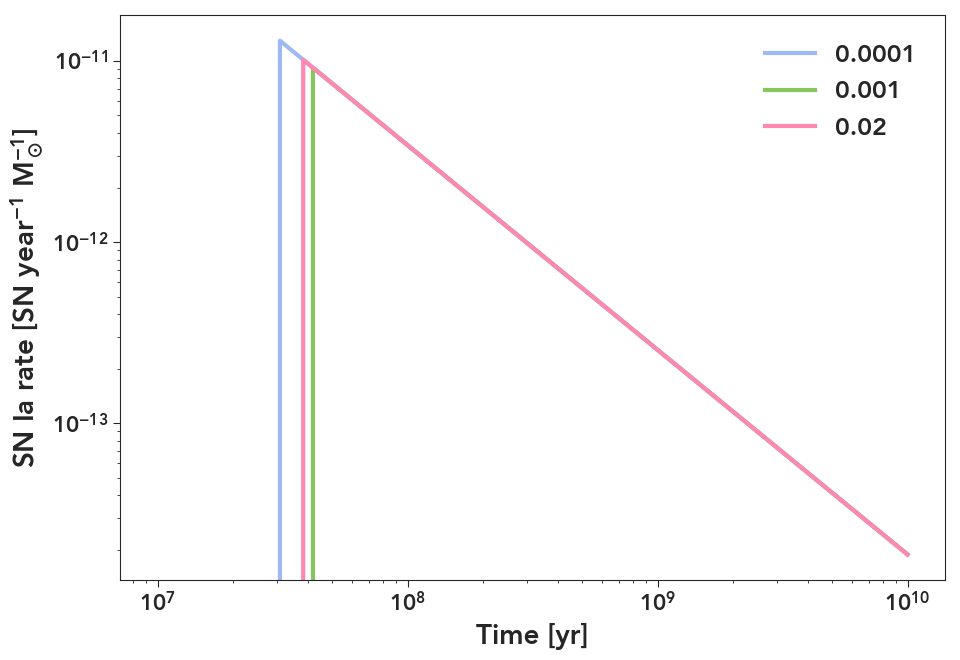

In [16]:
fig, ax = bpl.subplots()
ages = np.logspace(7, 10, 1000)
for z in z_plot:
    rate_final = [final_art_rate(a, z, true_N) for a in ages]
    ax.plot(ages, rate_final, label=z)
    
ax.add_labels("Time [yr]", "SN Ia rate [SN year$^{-1}$ M$^{-1}_\odot$]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

# Checking variations in the normalization

In ART there will be a parameter that controls the number of SN Ia per SSP. If this is varied I want to be able to vary the prescription. I am 100% sure I can just scale the normalization, since it's linear, but want numerical proof.

I'll just check this at solar metallicity, since that is where the normalization is done.

In [17]:
z = 0.02
for N in [1.3E-3, 1E-3, 1E-2, 1.787982E-2]:
    age_8 = lifetimes.lifetime(8, z)
    integral= integrate.quad(final_art_rate, age_8, t_hubble, args=(z, N))[0]
    print("{:.6E}  {:.6E}".format(N, integral))

1.300000E-03  1.300000E-03
1.000000E-03  1.000000E-03
1.000000E-02  1.000000E-02
1.787982E-02  1.787982E-02


So yes, this works.

# Final ART prescription

I will use a DTD of the form:

$ r(t, z) = N_{\rm SN Ia} * 2.3480851917 * t^{-1} $ if $ t > \tau(M=8 M_\odot, \ z) $

$ r(t, z) = 0$ if $ t < \tau(M=8 M_\odot, \ z) $

where $t$ is in years.